In [1]:
# --- Import default libs ---
import os
import warnings
import yaml
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt

# --- Set working directory ---
PROJECT_DIR = Path().resolve()
PROJECT_ROOT_NAME = 'spectroscopy-regression'

while PROJECT_DIR.name != PROJECT_ROOT_NAME and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

if Path().resolve() != PROJECT_DIR:
    os.chdir(PROJECT_DIR)

# --- Import customized modules ---
from src.config import SineKAN_Config
from src.utils import CSVDataset
from src.models import MultiLayerSineKAN

# --- Import PyTorch modules ---
from torch.utils.data import DataLoader, random_split
import torch

In [2]:
# Configuration
MODEL_PATH = "log/MultiLayerSineKAN/best/run_01.pt"
CONFIG_PATH = "config/train_kan.yaml"
DATA_DIR = "data/merged_dropna.csv"
BATCH_SIZE = 16

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset
dataset = CSVDataset(DATA_DIR)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Initialize model
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

model_config = SineKAN_Config.from_dict(config['model'])
model = MultiLayerSineKAN(config=model_config)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

MultiLayerSineKAN(
  (layers): ModuleList(
    (0-1): 2 x SineKAN()
  )
)

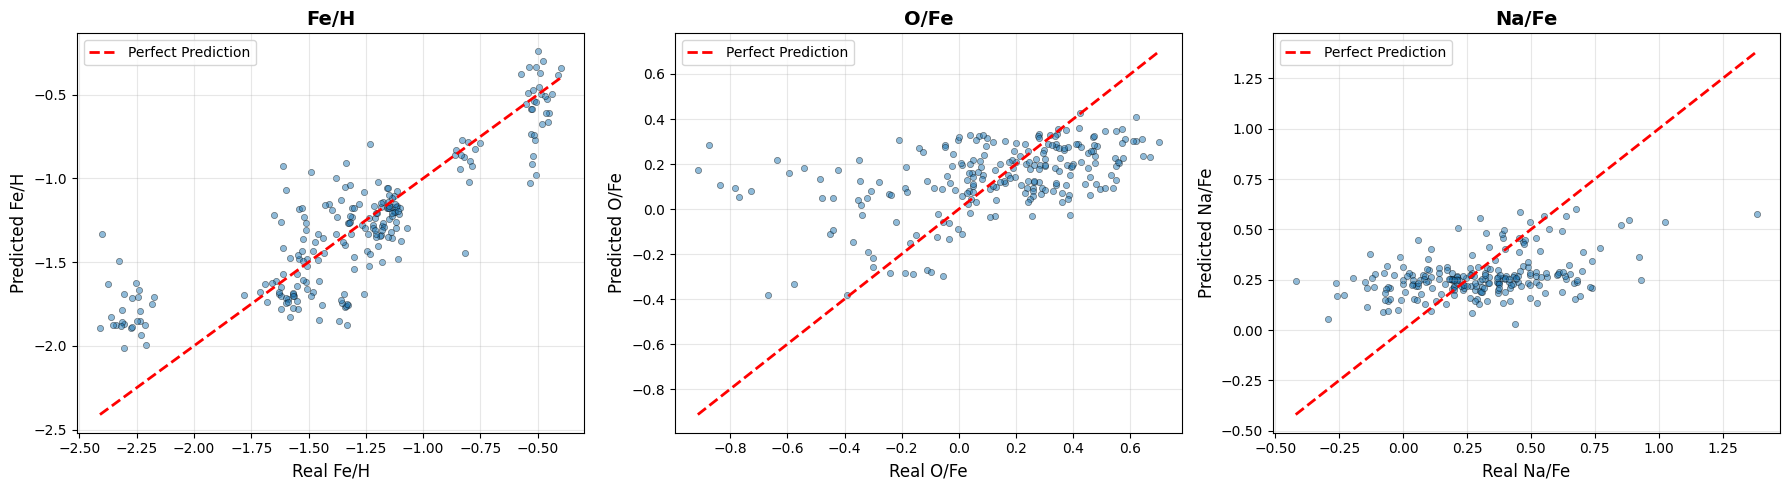

In [3]:
# Run inference
predictions = []
targets = []

with torch.no_grad():
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        
        # Store results
        predictions.extend(y_pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

predictions = np.array(predictions)  
targets = np.array(targets) 

# Vizualize
dim_names = ['Fe/H', 'O/Fe', 'Na/Fe']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(dim_names):
    pred_i = predictions[:, i]
    target_i = targets[:, i]
    
    axes[i].scatter(target_i, pred_i, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    axes[i].plot([target_i.min(), target_i.max()], [target_i.min(), target_i.max()], 
                'r--', lw=2, label='Perfect Prediction')
    axes[i].set_xlabel(f'Real {name}', fontsize=12)
    axes[i].set_ylabel(f'Predicted {name}', fontsize=12)
    axes[i].set_title(f'{name}', fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()